In [33]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
import zipfile
from sklearn.model_selection import train_test_split

Extraction des images: 100%|██████████| 1000/1000 [00:01<00:00, 625.08it/s]


['10054.jpg', '10062.jpg', '10065.jpg', '10096.jpg', '10250.jpg', '10257.jpg', '10259.jpg', '10266.jpg', '10268.jpg', '10292.jpg']
['sample_image\\data_image\\10054.jpg', 'sample_image\\data_image\\10062.jpg', 'sample_image\\data_image\\10065.jpg', 'sample_image\\data_image\\10096.jpg', 'sample_image\\data_image\\10250.jpg', 'sample_image\\data_image\\10257.jpg', 'sample_image\\data_image\\10259.jpg', 'sample_image\\data_image\\10266.jpg', 'sample_image\\data_image\\10268.jpg', 'sample_image\\data_image\\10292.jpg']


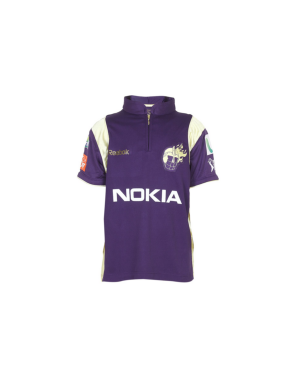

In [34]:
# Chemin du fichier zip
zip_file_path = 'data_image.zip'

# Dossier de destination
destination_folder = 'sample_image'

# Créer le dossier de destination s'il n'existe pas
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extraire le contenu des images directement dans le dossier destination
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Parcourir les fichiers dans le zip
   for file in tqdm(zip_ref.namelist(), desc="Extraction des images"):
        # Extraire chaque fichier dans le dossier de destination
        zip_ref.extract(file, destination_folder)

directory_path = os.path.join(destination_folder, 'data_image')
files = os.listdir(directory_path)
print(files[:10])

# Function to load and display an image
def display_image(file_path):
    image = Image.open(file_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# list all image files with the specified extensions
image_paths_list = [file for file in glob.glob(os.path.join(directory_path, '*.*')) if file.endswith(('.jpg'))]
print(image_paths_list[:10])

# Display the first image to understand its characteristics
first_image_path = os.path.join(directory_path, files[0])
display_image(first_image_path)

In [35]:
df = pd.read_csv('styles.csv', on_bad_lines='skip')
df['image'] = df.apply(lambda row:str(row['id']) + '.jpg',axis=1)
df = df.reset_index(drop=True)
sample_images = {os.path.splitext(f)[0] for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))}

# Filtrer le DataFrame pour inclure uniquement les images disponibles dans 'sample_image'
df = df[df['id'].astype(str).isin(sample_images)]
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


# Construction du Model 

Le modèle VGG16 est chargé sans sa couche de classification supérieure (include_top=False), ce qui le rend adapté à l'extraction de fonctionnalités plutôt qu'à la classification. Chaque chemin d'image de image_paths_list est traité en une série d'étapes : l'image est chargée et redimensionnée à 224 × 224 pixels pour correspondre aux exigences de taille d'entrée VGG16, convertie en tableau NumPy et prétraitée pour s'adapter au format d'entrée attendu du modèle.

Les images prétraitées sont ensuite introduites dans le modèle VGG16 pour extraire les caractéristiques, qui sont ensuite aplaties et normalisées afin de créer un vecteur de caractéristiques cohérent pour chaque image. Ces vecteurs de caractéristiques (all_features) et leurs noms de fichiers d'image correspondants (all_image_names) sont stockés, fournissant un ensemble de données structuré pour les prochaines étapes de la création d'un système de recommandation de mode utilisant des caractéristiques d'image.

In [36]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

In [37]:
# Diviser les données en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_image_paths = [os.path.join(directory_path, img) for img in train_df['image']]
test_image_paths = [os.path.join(directory_path, img) for img in test_df['image']]

In [38]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

def extract_features(model, preprocessed_img):
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

def extract_features_for_dataset(image_paths):
    all_features = []
    all_image_names = []
    for img_path in image_paths:
        preprocessed_img = preprocess_image(img_path)
        features = extract_features(model, preprocessed_img)
        all_features.append(features)
        all_image_names.append(os.path.basename(img_path))
    return np.array(all_features), all_image_names

train_features, train_image_names = extract_features_for_dataset(train_image_paths)
test_features, test_image_names = extract_features_for_dataset(test_image_paths)


1/1 [==============================] - 0s 109ms/step


In [39]:
from scipy.spatial.distance import cosine

# Fonction de recommandation
def recommend_fashion_items_cnn(input_image_path, all_features, all_image_names, model, top_n=5):
    # Pre-process the input image and extract features
    preprocessed_img = preprocess_image(input_image_path)
    input_features = extract_features(model, preprocessed_img)

    # Calculate similarities and find the top N similar images
    similarities = [1 - cosine(input_features, other_feature) for other_feature in all_features]
    similar_indices = np.argsort(similarities)[-top_n:]

    # Extract the filename from input_image_path
    input_image_filename = os.path.basename(input_image_path)

    # Filter out the input image index from similar_indices
    similar_indices = [idx for idx in similar_indices if all_image_names[idx] != input_image_filename]

    if not similar_indices:
        print(f"No similar images found for {input_image_filename}")
        return []

    # Store paths of similar images
    recommended_image_paths = []
    for idx in similar_indices[:top_n]:
        image_path = os.path.join(all_image_names[idx])
        # vérifier si l'image existe sinon réécrire le chemin 
        if not os.path.exists(image_path):
            image_path = os.path.join(directory_path, image_path)
            
        recommended_image_paths.append(image_path)

    return recommended_image_paths


def display_recommendations(input_image_path, recommended_image_paths, top_n=5):
    # Display the input image
    plt.figure(figsize=(15, 10))
    plt.subplot(1, top_n + 1, 1)
    plt.imshow(Image.open(input_image_path))
    plt.title("Input Image")
    plt.axis('off')

    # Display similar images
    for i, image_path in enumerate(recommended_image_paths[:top_n], start=1):
        plt.subplot(1, top_n + 1, i + 1)
        plt.imshow(Image.open(image_path))
        plt.title(f"Recommendation {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Système de recommandation

1/1 [==============================] - 0s 106ms/step


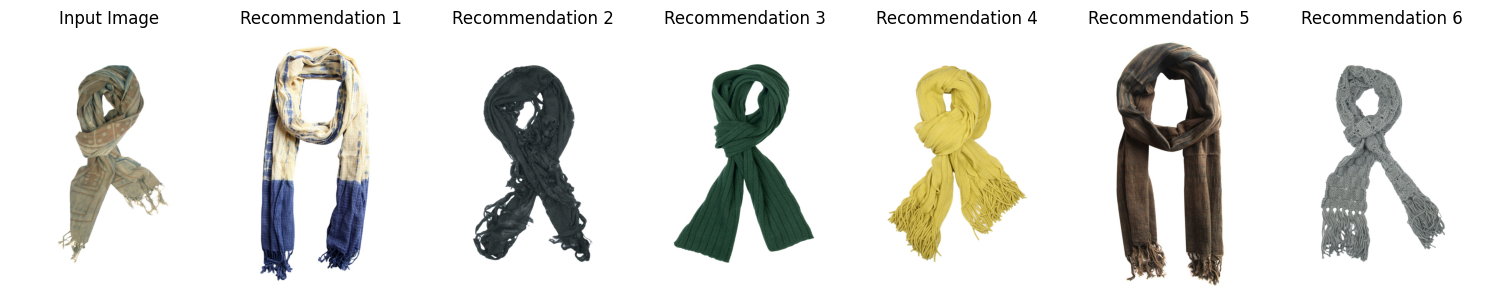

In [40]:
# Exemple d'utilisation des fonctions
input_image_path = test_image_paths[28]
recommended_image_paths = recommend_fashion_items_cnn(input_image_path, train_features, train_image_names, model, top_n=6)
display_recommendations(input_image_path, recommended_image_paths, top_n=6)

# Evaluation

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
import seaborn as sns

def evaluate_model(y_true, y_pred):
    valid_indices = [i for i, pred in enumerate(y_pred) if pred != 'Unknown']
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
    precision = precision_score(y_true_filtered, y_pred_filtered, average='weighted')
    recall = recall_score(y_true_filtered, y_pred_filtered, average='weighted')
    f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted')

    print("Métriques d'évaluation ............................................")
    print("\n")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    print("\nMatrice de confusion ............................................")
    conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [42]:
y_true = []
y_pred = []

for img_path in test_image_paths:
    true_class = test_df[test_df['image'] == os.path.basename(img_path)]['articleType'].values[0]
    y_true.append(true_class)

    recommended_images = recommend_fashion_items_cnn(img_path, train_features, train_image_names, model, top_n=1)
    if recommended_images:
        predicted_class = train_df[train_df['image'] == os.path.basename(recommended_images[0])]['articleType'].values[0]
        y_pred.append(predicted_class)
    else:
        y_pred.append('Unknown')


1/1 [==============================] - 0s 125ms/step


Métriques d'évaluation ............................................


Accuracy:  0.705
Precision:  0.6790595238095238
Recall:  0.705
F1 Score:  0.6809762835730578

Matrice de confusion ............................................


c:\Users\Hugues GBEGAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hugues GBEGAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


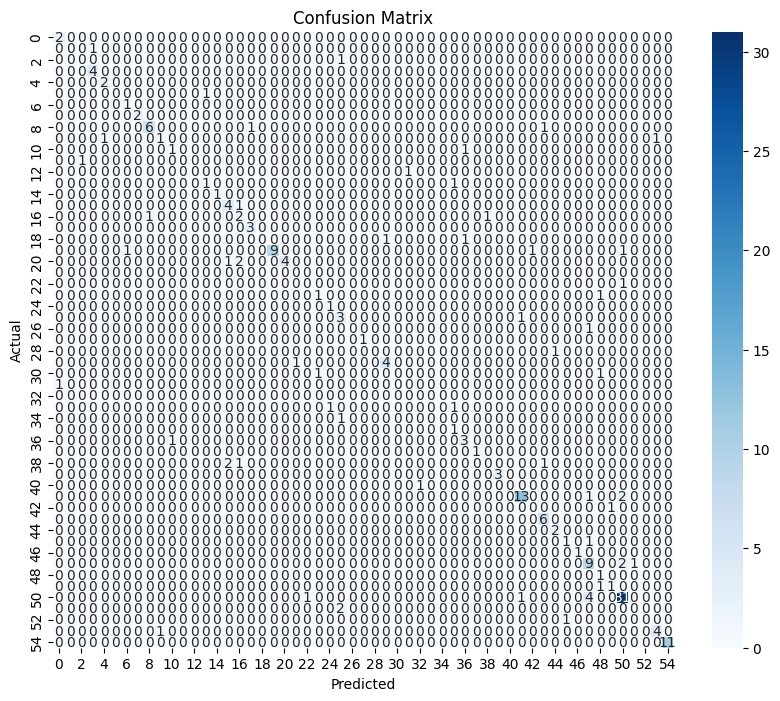

In [43]:
evaluate_model(y_true, y_pred)